In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['image_id'] = train['image_id']+'.jpg'
test['image_id'] = test['image_id'] +'.jpg'

train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0
3,Train_3.jpg,0,0,1,0
4,Train_4.jpg,1,0,0,0


In [3]:
img=[]
filename=train.image_id
for file in filename:
    image=cv2.imread("images/"+file)
    res=cv2.resize(image,(256,256))
    img.append(res)
img=np.array(img)

In [4]:
img.shape

(1821, 256, 256, 3)

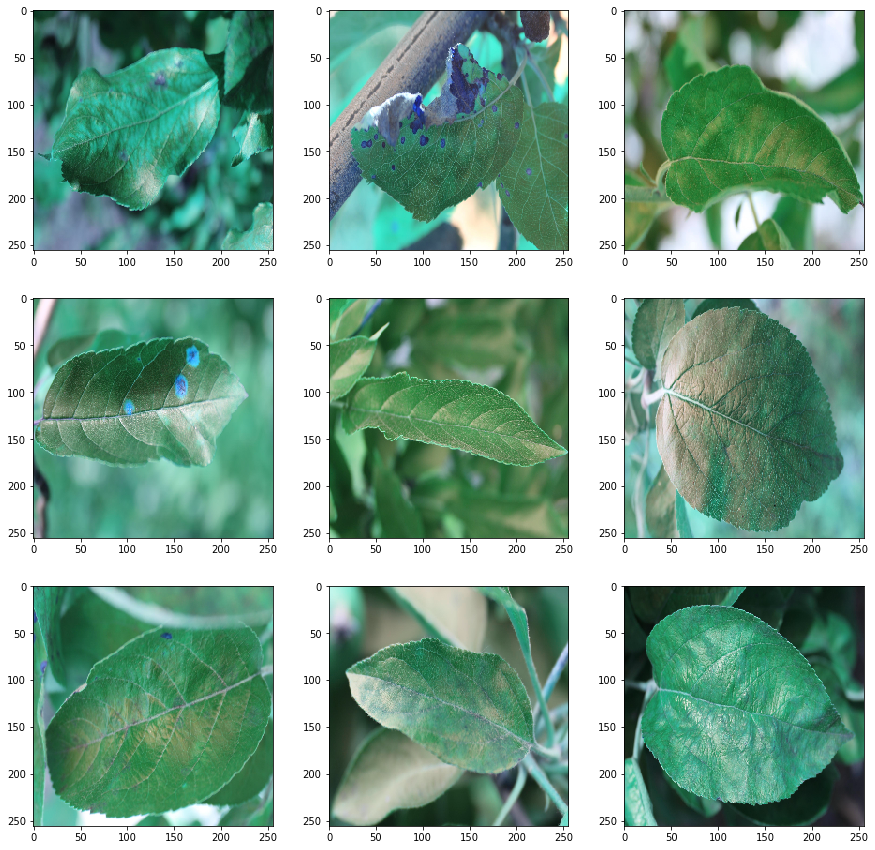

In [5]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i])

In [6]:
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)



In [7]:
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [8]:
train, val = train_test_split(train, test_size = 0.15)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    fill_mode='nearest',
    shear_range=0.1,
    rescale=1/255,
    brightness_range=[0.5, 1.5])

In [10]:
train_generator = train_datagen.flow_from_dataframe(
                train, directory = 'D:/Plant_Pathology_kaggle/plant-pathology-2020-fgvc7/images/',
                target_size = (128,128),
                x_col = 'image_id',
                y_col = ['healthy','multiple_diseases','rust','scab'],
                class_mode='raw',
                shuffle=False,
                subset='training',
                batch_size = 16
)

Found 1547 validated image filenames.


In [11]:
val_generator=train_datagen.flow_from_dataframe(val,directory='D:/Plant_Pathology_kaggle/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(128,128),
                                                      x_col="image_id",
                                                      y_col=['healthy','multiple_diseases','rust','scab'],
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=16,
                                                  )

Found 274 validated image filenames.


In [12]:
test_generator=train_datagen.flow_from_dataframe(test,directory='D:/Plant_Pathology_kaggle/plant-pathology-2020-fgvc7/images/',
                                                      target_size=(128,128),
                                                      x_col="image_id",
                                                      y_col=None,
                                                      class_mode=None,
                                                      shuffle=False,
                                                      batch_size=16)

Found 1821 validated image filenames.


In [13]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
import keras
from keras import optimizers

import tensorflow as tf

In [14]:
pretrained_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128,128,3))

In [15]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    
  
    tf.keras.layers.Dense(4, activation='softmax')  
    ])


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'] 

)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________


In [18]:
from keras.callbacks import ReduceLROnPlateau

In [19]:
history_1 = model.fit_generator(train_generator,steps_per_epoch=20,
                               epochs=250, validation_data=val_generator,
                               validation_steps=100,
                               verbose = 1, callbacks=[ReduceLROnPlateau(monitor= 'loss', factor=0.3, patience=3, min_lr=0.000001)],
                                use_multiprocessing=False,
                               shuffle=True
                               )



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/250
20/20 [==============================] - 12s 592ms/step - loss: 1.1702 - acc: 0.5437 - val_loss: 1.3948 - val_acc: 0.3467
Epoch 2/250
20/20 [==============================] - 8s 389ms/step - loss: 1.0806 - acc: 0.6571
Epoch 3/250
20/20 [==============================] - 5s 258ms/step - loss: 1.0996 - acc: 0.6375
Epoch 4/250
20/20 [==============================] - 5s 257ms/step - loss: 1.0815 - acc: 0.6594
Epoch 5/250
20/20 [==============================] - 5s 261ms/step - loss: 1.0333 - acc: 0.7094
Epoch 6/250
20/20 [==============================] - 5s 263ms/step - loss: 1.0531 - acc: 0.6875
Epoch 7/250
20/20 [==============================] - 5s 262ms/step - loss: 1.1106 - acc: 0.6375
Epoch 8/250
20/20 [==============================] - 5s 265ms/step - loss: 1.0735 - acc: 0.6719
Epoch 9/250
20/20 [==============================] - 5s 263ms/step - loss: 1.0592 - acc: 0.6781
Epoch 10/250
20/20 [==

Epoch 79/250
20/20 [==============================] - 6s 291ms/step - loss: 0.8960 - acc: 0.8469
Epoch 80/250
20/20 [==============================] - 8s 386ms/step - loss: 0.8801 - acc: 0.8656
Epoch 81/250
20/20 [==============================] - 7s 345ms/step - loss: 0.8828 - acc: 0.8562
Epoch 82/250
20/20 [==============================] - 6s 322ms/step - loss: 0.9527 - acc: 0.7906
Epoch 83/250
20/20 [==============================] - 6s 294ms/step - loss: 0.9107 - acc: 0.8344
Epoch 84/250
20/20 [==============================] - 5s 273ms/step - loss: 0.8559 - acc: 0.8857
Epoch 85/250
20/20 [==============================] - 6s 282ms/step - loss: 0.9233 - acc: 0.8188
Epoch 86/250
20/20 [==============================] - 8s 376ms/step - loss: 0.8774 - acc: 0.8635
Epoch 87/250
20/20 [==============================] - 6s 305ms/step - loss: 0.8751 - acc: 0.8594
Epoch 88/250
20/20 [==============================] - 6s 293ms/step - loss: 0.8765 - acc: 0.8667
Epoch 89/250
20/20 [==========

20/20 [==============================] - 5s 271ms/step - loss: 0.8760 - acc: 0.8656
Epoch 163/250
20/20 [==============================] - 6s 277ms/step - loss: 0.9265 - acc: 0.8062
Epoch 164/250
20/20 [==============================] - 6s 279ms/step - loss: 0.8684 - acc: 0.8781
Epoch 165/250
20/20 [==============================] - 5s 273ms/step - loss: 0.8875 - acc: 0.8540
Epoch 166/250
20/20 [==============================] - 6s 278ms/step - loss: 0.8732 - acc: 0.8687
Epoch 167/250
20/20 [==============================] - 6s 307ms/step - loss: 0.8817 - acc: 0.8635
Epoch 168/250
20/20 [==============================] - 6s 308ms/step - loss: 0.8896 - acc: 0.8540
Epoch 169/250
20/20 [==============================] - 6s 284ms/step - loss: 0.8941 - acc: 0.8469
Epoch 170/250
20/20 [==============================] - 6s 291ms/step - loss: 0.8627 - acc: 0.8844
Epoch 171/250
20/20 [==============================] - 6s 277ms/step - loss: 0.9163 - acc: 0.8250
Epoch 172/250
20/20 [=============

20/20 [==============================] - 6s 280ms/step - loss: 0.8442 - acc: 0.9031
Epoch 246/250
20/20 [==============================] - 6s 282ms/step - loss: 0.9081 - acc: 0.8313
Epoch 247/250
20/20 [==============================] - 6s 276ms/step - loss: 0.9258 - acc: 0.8156
Epoch 248/250
20/20 [==============================] - 5s 271ms/step - loss: 0.8499 - acc: 0.8952
Epoch 249/250
20/20 [==============================] - 6s 276ms/step - loss: 0.8739 - acc: 0.8656
Epoch 250/250
20/20 [==============================] - 6s 276ms/step - loss: 0.8713 - acc: 0.8719


In [22]:
SUB_PATH = "sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
probs_RESNET = model.predict(test_generator, verbose=1)
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv('submission.csv', index=False)
sub.head()

114/114 [==============================] - 71s 625ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.629662e-05,9.870513e-06,9.994587e-01,5.151000e-04
1,Test_1,9.193520e-10,1.268767e-09,1.000000e+00,2.170213e-09
2,Test_2,9.465316e-09,2.820365e-09,1.013868e-08,1.000000e+00
3,Test_3,9.999993e-01,3.692154e-07,3.223184e-07,9.108366e-08
4,Test_4,2.039490e-23,6.158811e-20,1.000000e+00,5.409478e-22


In [21]:
tf.keras.models.save_model(model, 'my_model.hdf5')